In [1]:
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from ff_energy.ffe.utils import read_from_pickle
import jax.numpy as jnp
from ff_energy.ffe.plot import plot_energy_MSE, plot_ff_fit
from ff_energy.ffe.structure import atom_key_pairs
from ff_energy.ffe.potential import LJ, akp_indx
from ff_energy.ffe.ff import FF
from ff_energy.ffe.ff_fit import LJ_bound, load_ff, fit_func, fit_repeat
from ff_energy.ffe.data import pairs_data
from ff_energy.ffe.utils import pickle_output, read_from_pickle, str2int




In [2]:
sig_bound = (0.001, 2.5)
ep_bound = (0.001, 2.5)
chg_bound = (100,2000)

CHGPEN_bound = [(chg_bound),(chg_bound),(chg_bound),(chg_bound),(0,2000)]
LJ_bound = ((sig_bound), (sig_bound), (ep_bound), (ep_bound))
DE_bound = ((sig_bound), (sig_bound), (ep_bound), (ep_bound), 
            (1, 8), (6, 20))

In [3]:
#  example
# ffpkl = "ECOL_pbe0dz_FOE.ff.pkl"
ffpkl = "kmdcm_pbe0dz_FOE.ff.pkl"

In [4]:
_c = next(read_from_pickle(f"ff/{ffpkl}"))
_c

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


FF: LJ water_cluster ELEC harmonic first_order_energy (jax_coloumb: True)

In [5]:
_c.intE = "ECOL"
_c.set_targets()
# _c.targets
# _c.data.ECOL
# _c.data.ELEC

In [6]:
fit_repeat(_c, 
           1, 
           f"{ffpkl}_chgpen",
           bounds = CHGPEN_bound,
           loss="chgpen",
           # quiet='true'
          )

Optimizing LJ parameters...
function: get_loss_chgpen
bounds: [(100, 2000), (100, 2000), (100, 2000), (100, 2000), (0, 2000)]
maxfev: 10000
initial guess: [1254.0144029521684, 783.3517514738868, 1536.251183290788, 744.4894315603029, 1255.0345416790042]


/home/boittier/Documents/phd/ff_energy/ff_energy/ffe/ff_fit.py:175: OptimizeWarning: Unknown solver options: pgtol
  res = minimize(


final_loss_fn:  134.3662872314453
       message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 134.3662872314453
             x: [ 1.405e+03  9.180e+02  1.854e+03  7.530e+02  2.639e+02]
           nit: 109
          nfev: 284
 final_simplex: (array([[ 1.405e+03,  9.180e+02, ...,  7.530e+02,
                         2.639e+02],
                       [ 1.405e+03,  9.180e+02, ...,  7.530e+02,
                         2.639e+02],
                       ...,
                       [ 1.405e+03,  9.180e+02, ...,  7.530e+02,
                         2.639e+02],
                       [ 1.405e+03,  9.180e+02, ...,  7.530e+02,
                         2.639e+02]]), array([ 1.344e+02,  1.344e+02,  1.344e+02,  1.344e+02,
                        1.344e+02,  1.344e+02]))


In [7]:
resx = _c.opt_parm 
loss = _c.get_loss_chgpen(resx)
loss
resx

array([1404.75993063,  917.96651247, 1853.84631062,  753.01126177,
        263.92948625])

In [8]:
np.sqrt(loss)

11.591647

5.656149153153502e-185


(<Axes: xlabel='NBOND energy\n(kcal/mol)', ylabel='CCSD(T) interaction energy\n(kcal/mol)'>,
 {'MSE': 134.36628164577786,
  'RMSE': 11.591647063544414,
  'R': 0.9031237932800752,
  'RS': 0.8898791115164458,
  'n': 500,
  'slope': 0.9645819909018784,
  'intercept': -2.762438703040317})

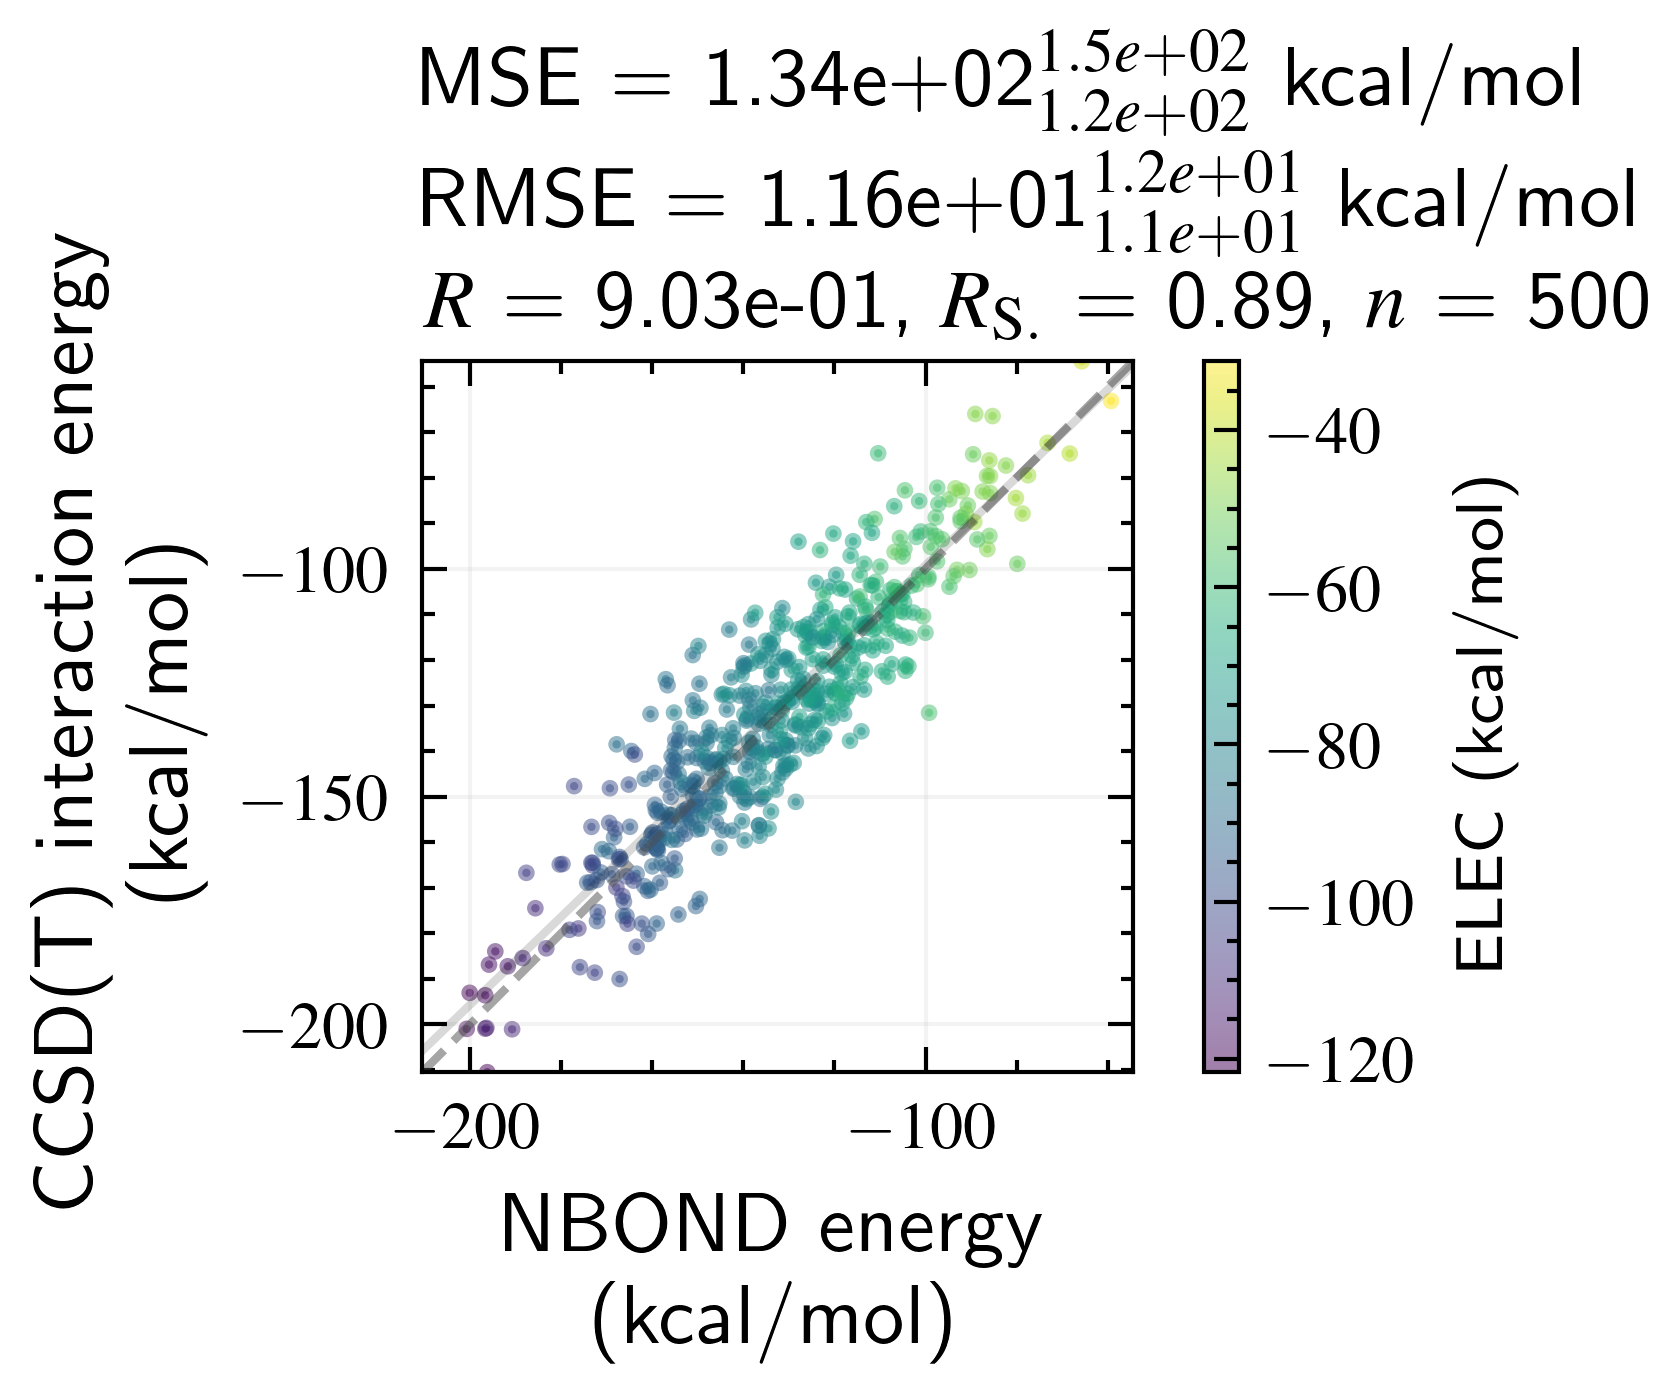

In [9]:
# _c.eval_jax_chgpen(resx ) 
_c.data["fit_ECOL"] = _c.eval_jax_chgpen(resx ) + _c.data.ELEC

plot_energy_MSE(_c.data, "ECOL", "fit_ECOL",  elec = "ELEC")


0.0


(<Axes: xlabel='NBOND energy\n(kcal/mol)', ylabel='CCSD(T) interaction energy\n(kcal/mol)'>,
 {'MSE': 3210.1909596343576,
  'RMSE': 56.65854710133642,
  'R': 0.974642974616211,
  'RS': 0.9712630530522122,
  'n': 500,
  'slope': 0.5898450470221722,
  'intercept': 0.7442057103565531})

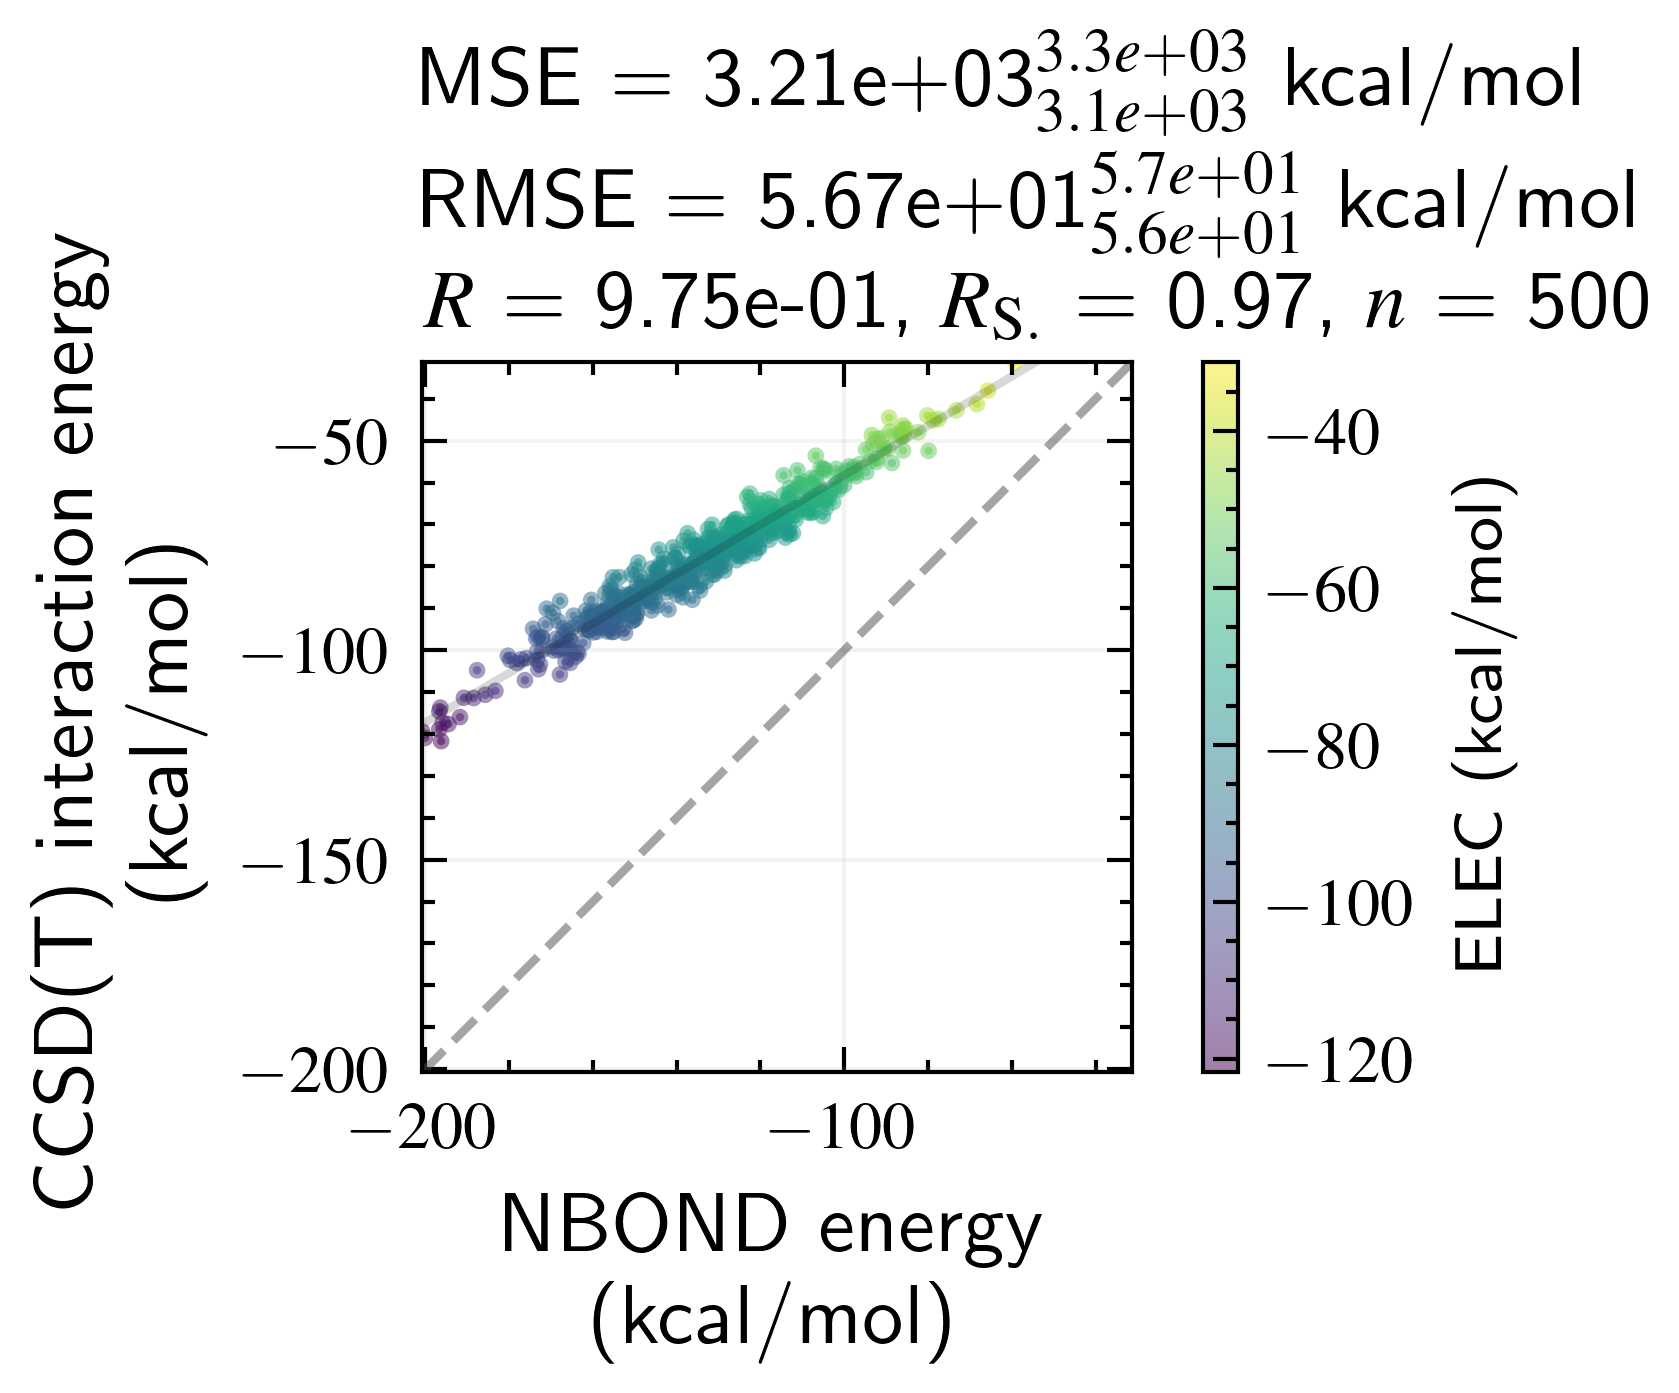

In [10]:
plot_energy_MSE(_c.data, "ECOL", "ELEC",  elec = "ELEC")

In [12]:
pickle_output(_c, "ff/fit_ECOL_kmdcm")

#  LJ fit


In [14]:
# _c = next(read_from_pickle(f"ff/{ffpkl}"))

LJFF = next(read_from_pickle(f"ff/fit_ECOL_kmdcm.pkl"))
LJFF.elec = "fit_ECOL"
LJFF

FF: LJ water_cluster fit_ECOL harmonic ECOL (jax_coloumb: True)

In [15]:
# _c.targets

In [19]:
fit_repeat(LJFF, 
           3, 
           f"{ffpkl}_LJ",
           bounds = LJ_bound,
           loss="jax",
           quiet='true'
          )

/home/boittier/Documents/phd/ff_energy/ff_energy/ffe/ff_fit.py:175: OptimizeWarning: Unknown solver options: pgtol
  res = minimize(


In [20]:
pd.DataFrame(LJFF.opt_results).sort_values("fun")

,fun,nit,nfev,status,success,message,x,final_simplex
6,11.244972,679,1151,0,True,Optimization terminated successfully.,"[0.5130468631348409, 1.0706950604509093, 2.5, ...","([[0.5130468631348409, 1.0706950604509093, 2.5..."
3,11.244985,357,629,0,True,Optimization terminated successfully.,"[0.5130763990195808, 1.0706901789051129, 2.5, ...","([[0.5130763990195808, 1.0706901789051129, 2.5..."
4,11.244997,552,945,0,True,Optimization terminated successfully.,"[0.5134834829737075, 1.0704344280502207, 2.5, ...","([[0.5134834829737075, 1.0704344280502207, 2.5..."
5,11.245038,263,480,0,True,Optimization terminated successfully.,"[0.5124140919024825, 1.0710510286287802, 2.499...","([[0.5124140919024825, 1.0710510286287802, 2.4..."
1,11.245096,204,389,0,True,Optimization terminated successfully.,"[0.5127709466738444, 1.0708655281706678, 2.499...","([[0.5127709466738444, 1.0708655281706678, 2.4..."
8,11.263123,459,803,0,True,Optimization terminated successfully.,"[0.5150478413778918, 1.0698426438349107, 2.491...","([[0.5150478413778918, 1.0698426438349107, 2.4..."
7,11.483284,306,557,0,True,Optimization terminated successfully.,"[0.5054998055173132, 1.0824930987117796, 2.5, ...","([[0.5054998055173132, 1.0824930987117796, 2.5..."
2,21.217991,238,412,0,True,Optimization terminated successfully.,"[0.001, 1.248999567239053, 2.5, 2.5]","([[0.001, 1.248999567239053, 2.5, 2.5], [0.001..."
0,134.366287,109,284,0,True,Optimization terminated successfully.,"[1404.7599306286556, 917.9665124727665, 1853.8...","([[1404.7599306286556, 917.9665124727665, 1853..."
9,3186.960693,112,229,0,True,Optimization terminated successfully.,"[1.2806986739770245, 0.001, 0.001, 2.5]","([[1.2806986739770245, 0.001, 0.001, 2.5], [1...."


In [29]:
best = list(pd.DataFrame(\
                  LJFF.opt_results)\
     .sort_values("fun").fun)[0]
np.sqrt(best)

3.353352386642941

#  DE fit


In [21]:
# _c = next(read_from_pickle(f"ff/{ffpkl}"))
DEFF = next(read_from_pickle(f"ff/fit_ECOL_kmdcm.pkl"))
DEFF.elec = "fit_ECOL"
DEFF

FF: LJ water_cluster fit_ECOL harmonic ECOL (jax_coloumb: True)

In [22]:
fit_repeat(DEFF, 
           10, 
           "test",
           bounds = DE_bound,
           loss="jax_de",
           quiet='true'
          )

/home/boittier/Documents/phd/ff_energy/ff_energy/ffe/ff_fit.py:175: OptimizeWarning: Unknown solver options: pgtol
  res = minimize(


In [24]:
pd.DataFrame(DEFF.opt_results).sort_values("fun")

,fun,nit,nfev,status,success,message,x,final_simplex
9,6.058845,714,1181,0,True,Optimization terminated successfully.,"[0.34505969834282724, 1.2875645060478798, 2.49...","([[0.34505969834282724, 1.2875645060478798, 2...."
3,6.062140,1549,2451,0,True,Optimization terminated successfully.,"[0.34477124733831327, 1.2875453361707134, 2.49...","([[0.34477124733831327, 1.2875453361707134, 2...."
6,6.068539,599,987,0,True,Optimization terminated successfully.,"[0.3434884057113549, 1.2883530519039779, 2.499...","([[0.3434884057113549, 1.2883530519039779, 2.4..."
1,6.077875,817,1337,0,True,Optimization terminated successfully.,"[0.34340599378211467, 1.2896911032128544, 2.49...","([[0.34340599378211467, 1.2896911032128544, 2...."
7,6.133962,1221,1969,0,True,Optimization terminated successfully.,"[0.34585048301928245, 1.286718935435089, 2.5, ...","([[0.34585048301928245, 1.286718935435089, 2.5..."
5,7.446713,800,1320,0,True,Optimization terminated successfully.,"[0.3640456028951608, 1.2786628182591642, 1.982...","([[0.3640456028951608, 1.2786628182591642, 1.9..."
4,8.835442,601,986,0,True,Optimization terminated successfully.,"[0.4391903591268382, 1.1499174999618944, 2.499...","([[0.4391903591268382, 1.1499174999618944, 2.4..."
10,28.333506,791,1297,0,True,Optimization terminated successfully.,"[0.8135516589666656, 0.8295798368402121, 0.761...","([[0.8135516589666656, 0.8295798368402121, 0.7..."
2,35.218937,402,694,0,True,Optimization terminated successfully.,"[0.9070174664677745, 0.0031701861861710093, 1....","([[0.9070174664677745, 0.0031701861861710093, ..."
0,134.366287,109,284,0,True,Optimization terminated successfully.,"[1404.7599306286556, 917.9665124727665, 1853.8...","([[1404.7599306286556, 917.9665124727665, 1853..."


In [25]:
list(pd.DataFrame(\
                  _c.opt_results)\
     .sort_values("fun").x)[0]

array([1404.75993063,  917.96651247, 1853.84631062,  753.01126177,
        263.92948625])

In [28]:
best = list(pd.DataFrame(\
                  DEFF.opt_results)\
     .sort_values("fun").fun)[0]
np.sqrt(best)

2.4614720324117467